<a href="https://colab.research.google.com/github/simhermansson/NLP_Yelp_Reviews/blob/main/NLP_Yelp_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predict Yelp Review Stars

### Read the two datasets to dataframes

We have one dataset for businesses, and one for reviews.
The businesses dataset is 113 MB, while the review dataset is almost 5 GB!

We must therefore be careful when loading that dataset to a dataframe to not run out of RAM.

In [1]:
# Specify whether training final model or only using some of the data
FINAL_MODEL = True

In [ ]:
!pip install pandas --quiet
import pandas as pd

from google.colab import drive


# Mount Google Drive
#drive.mount("/content/drive")

# Read business data to dataframe
business_df = pd.read_json("/content/drive/MyDrive/Colab Data/yelp_academic_dataset_business.json",
                           lines=True)
# Keep only strictly necessary columns
business_df = business_df[["business_id", "stars", "review_count"]]

# Read review data to a JsonReader object, due to memory constraints
review_df = None
with pd.read_json("/content/drive/MyDrive/Colab Data/yelp_academic_dataset_review.json",
                  lines=True,
                  chunksize=1000000) as reader:
    # Keep only necessary columns and combine into a full dataframe
    for chunk in reader:
        chunk = chunk[["business_id", "stars", "text"]]
        review_df = chunk if review_df is None else pd.concat([review_df, chunk],
                                                              ignore_index=True)
    del chunk

# Use a smaller review dataset if not training the final model
if not FINAL_MODEL:
    review_df = review_df.sample(frac=0.01, random_state=42).reset_index(drop=True)
else:
    review_df = review_df.sample(frac=0.2, random_state=42).reset_index(drop=True)

# Create train, validation and test sets for the review data
# Setting validation set to be very small in relation to the other sets, so it can be run through
# relatively quickly during training of DistilBert
train_review_df = review_df.sample(frac=0.8, random_state=42)
valid_review_df = review_df.drop(train_review_df.index).reset_index(drop=True)
train_review_df = train_review_df.reset_index(drop=True)

test_review_df = valid_review_df.sample(frac=0.9965667, random_state=42)
valid_review_df = valid_review_df.drop(test_review_df.index).reset_index(drop=True)
test_review_df = test_review_df.reset_index(drop=True)

del review_df

#### Save the development train and test dataframes to avoid having to read and modify the entire dataset every time.

In [ ]:
if not FINAL_MODEL:
    train_review_df.to_csv("/content/drive/MyDrive/Colab Data/dev_train_review_df.csv", index=False)
    valid_review_df.to_csv("/content/drive/MyDrive/Colab Data/dev_valid_review_df.csv", index=False)
    test_review_df.to_csv("/content/drive/MyDrive/Colab Data/dev_test_review_df.csv", index=False)
else:
    train_review_df.to_csv("/content/drive/MyDrive/Colab Data/full_train_review_df.csv", index=False)
    valid_review_df.to_csv("/content/drive/MyDrive/Colab Data/full_valid_review_df.csv", index=False)
    test_review_df.to_csv("/content/drive/MyDrive/Colab Data/full_test_review_df.csv", index=False)

#### Read already saved training and test dataframes

In [2]:
!pip install datasets --quiet

from datasets import load_dataset, Features, Value, ClassLabel, concatenate_datasets, DownloadMode

import pandas as pd


features = Features({
    "business_id": Value(dtype="string"),
    "text": Value(dtype="string"),
    "stars": ClassLabel(num_classes=5, names=["1", "2", "3", "4", "5"])
})

if not FINAL_MODEL:
    train_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/dev_train_review_df.csv",
                                features=features)["train"]
    valid_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/dev_valid_review_df.csv",
                                features=features)["train"]
    test_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/dev_test_review_df.csv",
                               features=features)["train"]
else:
    train_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/full_train_review_df.csv",
                                features=features, download_mode=DownloadMode.FORCE_REDOWNLOAD)["train"]
    valid_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/full_valid_review_df.csv",
                                features=features, download_mode=DownloadMode.FORCE_REDOWNLOAD)["train"]
    test_review = load_dataset("csv", data_files="/content/drive/MyDrive/Colab Data/full_test_review_df.csv",
                               features=features, download_mode=DownloadMode.FORCE_REDOWNLOAD)["train"]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.9/452.9 KB 18.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.4/182.4 KB 20.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 18.6 MB/s eta 0:00:00


Computing checksums: 100%|##########| 1/1 [00:11<00:00, 11.04s/it]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4173e615d8aa166f/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-8e74c420f9732786/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Dataset csv downloaded and prepared to /root/.cache/huggingface/datasets/csv/default-4772872be49cda33/0.0.0/6b34fb8fcf56f7c8ba51dc895bfa2bfbe43546f190a60fcf74bb5e8afdcc2317. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

#### Make datasets ready to be used, remove unused columns and rename to HuggingFace standards

In [3]:
train_review = train_review.remove_columns("business_id")
valid_review = valid_review.remove_columns("business_id")
test_review = test_review.remove_columns("business_id")

train_review = train_review.rename_column("stars", "labels")
valid_review = valid_review.rename_column("stars", "labels")
test_review = test_review.rename_column("stars", "labels")

print(train_review.features)

{'text': Value(dtype='string', id=None), 'labels': ClassLabel(names=['1', '2', '3', '4', '5'], id=None)}


# Fine-tune a DistilBert Model

In [4]:
!pip install transformers wandb==0.13.4 torch --quiet

from transformers import (AutoTokenizer, DataCollatorWithPadding,
                          AutoModelForSequenceClassification, TrainingArguments, Trainer)
from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset, load_metric
import wandb

import numpy as np


# Use the GPU
device = "cuda"

# Load pre-trained DistilBert model from HuggingFace
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=5)

# Tokenize the training and validation data
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

train_review = train_review.map(
    lambda row: tokenizer(row["text"], truncation=True)
, batched=True)
valid_review = valid_review.map(
    lambda row: tokenizer(row["text"], truncation=True)
, batched=True)
test_review = test_review.map(
    lambda row: tokenizer(row["text"], truncation=True)
, batched=True)

# Create a collator that converts input into tensors and builds batches
collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Create a function for the evaluation metrics that are to be used
def metrics(eval):
    logits, labels = eval
    predictions = np.argmax(logits, axis=-1)
    acc = load_metric("accuracy").compute(predictions=predictions, references=labels)["accuracy"]
    f1 = load_metric("f1").compute(predictions=predictions, references=labels,
                                   average="weighted")["f1"]
    return {"Accuracy": acc, "F1-Score": f1}

# Set up training arguments
args = TrainingArguments(
    output_dir="/content/drive/MyDrive/Colab Data/models",
    overwrite_output_dir=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    num_train_epochs=0.5,
    save_strategy="steps",
    save_steps=200,
    logging_steps=200,
    eval_steps=200,
    evaluation_strategy="steps"
)

# Set up HuggingFace trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_review,
    eval_dataset=valid_review,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=metrics
)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 92.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 74.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.4/177.4 KB 22.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.0/184.0 KB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 105.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 KB 8.5 MB/s eta 0:00:00


Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_projector.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.bias', 'classifier

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

  0%|          | 0/1119 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/279 [00:00<?, ?ba/s]

In [ ]:
# Initialize weight and biases for tracking metrics
wandb.init()

# Train the model
trainer.train()

# Evaluate the model
trainer.evaluate()

# End wandb logging
wandb.finish()

#### Calculate performance on the test set

In [5]:
# Load saved fine-tuned model
model = AutoModelForSequenceClassification.from_pretrained("/content/drive/MyDrive/Colab Data/models/checkpoint-15600", num_labels=5)

# Load the saved model to the trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_review,
    eval_dataset=valid_review,
    tokenizer=tokenizer,
    data_collator=collator,
    compute_metrics=metrics
)

# Predict on the test set
trainer.predict(test_review)

loading configuration file /content/drive/MyDrive/Colab Data/models/checkpoint-15600/config.json
Model config DistilBertConfig {
  "_name_or_path": "/content/drive/MyDrive/Colab Data/models/checkpoint-15600",
  "activation": "gelu",
  "architectures": [
    "DistilBertForSequenceClassification"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3,
    "LABEL_4": 4
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "problem_type": "single_label_classification",
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "torch_dtype": "float32",
  "transformers_version": "4.25.1",
  "vocab_size": 30

<ipython-input-4-c343649e235a>:38: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  acc = load_metric("accuracy").compute(predictions=predictions, references=labels)["accuracy"]


PredictionOutput(predictions=array([[ 5.742158  , -0.15436456, -2.6700296 , -3.9349568 , -2.6774628 ],
       [ 1.7267905 ,  1.5333879 ,  0.13872322, -1.9988109 , -3.0943203 ],
       [ 0.22677197, -2.002072  , -2.0459743 , -1.3447785 ,  2.1366904 ],
       ...,
       [-5.821963  , -5.8427715 , -2.2196681 ,  2.210648  ,  4.28728   ],
       [-4.2614055 , -2.849276  ,  0.50671476,  1.6384153 ,  0.9448307 ],
       [-4.9014053 , -4.23638   , -1.0022593 ,  1.9643029 ,  2.653538  ]],
      dtype=float32), label_ids=array([0, 0, 4, ..., 4, 2, 4]), metrics={'test_loss': 0.5618391036987305, 'test_Accuracy': 0.7616875589895604, 'test_F1-Score': 0.7530561208766763, 'test_runtime': 4290.3215, 'test_samples_per_second': 64.949, 'test_steps_per_second': 2.03})

# Predicting Business Ratings by Embeddings and kNN

In [ ]:
text = "This was the best restaurant I've ever been to!"
encoding = tokenizer(text, truncation=True)
outputs = model(encoding, output_hidden_states=True)
hidden_states = outputs.hidden_states

# Baseline Methods

#### Set up the datasets

In [ ]:
# Combine train and validation sets, as we only do hyperparameter tuning with cross-validation here
train_review = concatenate_datasets([train_review, valid_review])

# Convert to pandas
train_review = train_review.to_pandas()
test_review = test_review.to_pandas()

# There were some NaNs, remove these
train_review.dropna(inplace=True)
train_review.head()
train_review["labels"] = train_review["labels"].astype("int64")
train_review["labels"]

del valid_review

#### Naive Bayes Classifier With CountVectorizer

In [ ]:
!pip install scikit-learn spacy --quiet
!python3 -m spacy download en_core_web_sm

import spacy
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC


# Load spacy
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess(text):
    """ Lemmatize, remove stop words and keep only alphabetic characters. """
    doc = nlp(text)
    return [t.lemma_ for t in doc if not t.is_stop and t.is_alpha]

# Create a pipeline with a CountVectorizer and a Naive Bayes Classifier
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("NB", MultinomialNB())])

pipe.fit(train_review["text"], train_review["labels"])

In [ ]:
# Do predictions
ys = pipe.predict(test_review["text"])
print(classification_report(test_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.62      0.71      0.66     42791
           1       0.32      0.29      0.30     21865
           2       0.38      0.33      0.35     27583
           3       0.43      0.56      0.49     58116
           4       0.80      0.69      0.74    129256

    accuracy                           0.60    279611
   macro avg       0.51      0.52      0.51    279611
weighted avg       0.62      0.60      0.60    279611



#### Naive Bayes Classifier With CountVectorizer Grid Search

Note: Should not be run with the complete dataset

In [ ]:
from sklearn.model_selection import GridSearchCV
# Parameters for grid search
parameters = {
    "vectorizer__binary": [True, False],
    "vectorizer__ngram_range": [(1, 1), (2, 2)],
    "NB__alpha": [1.0, 0.1]
}

pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("NB", MultinomialNB())])
gsc = GridSearchCV(pipe, parameters)
gsc.fit(train_review["text"].sample(frac=0.3), train_review["labels"].sample(frac=0.3))

In [ ]:
# Do predictions for the best parameters found during grid search, and show best parameters
ys = gsc.best_estimator_.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))
print(gsc.best_params_)

              precision    recall  f1-score   support

           0       0.23      0.02      0.03      2119
           1       0.07      0.00      0.00      1127
           2       0.00      0.00      0.00      1362
           3       0.19      0.04      0.07      2898
           4       0.46      0.94      0.62      6475

    accuracy                           0.45     13981
   macro avg       0.19      0.20      0.14     13981
weighted avg       0.29      0.45      0.31     13981

{'NB__alpha': 1.0, 'vectorizer__binary': True, 'vectorizer__ngram_range': (1, 1)}


#### Complete run with best hyperparameters

In [ ]:
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess, binary=True)),
                 ("NB", MultinomialNB())])

pipe.fit(train_review["text"], train_review["labels"])

Pipeline(steps=[('vectorizer',
                 CountVectorizer(binary=True,
                                 tokenizer=<function preprocess at 0x7f492e590310>)),
                ('NB', MultinomialNB())])

In [ ]:
# Do predictions
ys = pipe.predict(test_review["text"])
print(classification_report(test_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.62      0.73      0.67     42791
           1       0.34      0.28      0.30     21865
           2       0.39      0.31      0.34     27583
           3       0.44      0.54      0.48     58116
           4       0.79      0.72      0.76    129256

    accuracy                           0.61    279611
   macro avg       0.52      0.52      0.51    279611
weighted avg       0.62      0.61      0.61    279611



#### SVM With CountVectorizer

In [ ]:
pipe = Pipeline([("vectorizer", CountVectorizer(tokenizer=preprocess)),
                 ("SVM", SVC(max_iter=10))])

pipe.fit(train_review["text"], train_review["labels"])

In [ ]:
# Do predictions
ys = pipe.predict(valid_review["text"])
print(classification_report(valid_review["labels"], ys))

              precision    recall  f1-score   support

           0       0.20      0.55      0.29      2119
           1       0.09      0.01      0.02      1127
           2       0.13      0.04      0.06      1362
           3       0.21      0.06      0.10      2898
           4       0.57      0.59      0.58      6475

    accuracy                           0.37     13981
   macro avg       0.24      0.25      0.21     13981
weighted avg       0.36      0.37      0.34     13981



### Plot review data

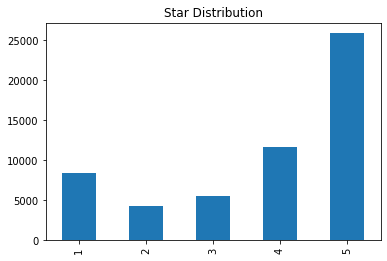

In [ ]:
import matplotlib.pyplot as plt

# Create a bar plot for the training data
train_review_df["stars"].value_counts().sort_index().plot(kind="bar")
plt.title("Star Distribution")
plt.show()

We can note that we have an uneven class balance in our dataset, with many 5-star reviews.